# Closed shell reactions with core correlation

Bak et al., [doi:10.1063/1.1357225](https://doi.org/10.1063/1.1357225) and [doi:10.1063/1.481544](https://doi.org/10.1063/1.481544)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pysjef import all_completed, DirectoryNode
from pysjef_molpro import no_errors, Project
from shutil import rmtree
from os.path import exists
pd.set_option("display.precision",2)

In [2]:
backend = 'local' # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Core_Valence_reactions'

In [3]:
methods = ['HF','MP2','MP3','PAPT2','PAPT3', 'CCSD','MP4','PAPT4', 'CCSD(T)']
# methods = ['PAPT3','PAPT4', 'CCSD(T)']
bases = ['cc-pCVDZ']
#bases = ['cc-pCVTZ']
#bases = ['cc-pCVQZ']
# bases = ['cc-pCVQZ','cc-pCV5Z']
# bases = ['cc-pCV5Z']
bases = ['cc-pCVDZ','cc-pCVTZ','cc-pCVQZ', 'cc-pCV5Z']
# bases = ['cc-pCVDZ','cc-pCVTZ','cc-pCVQZ']
# bases = ['cc-pCVDZ','cc-pCVTZ']

In [4]:
closed_shell_methods={'B3LYP' : "ks, b3lyp", "HF" : "hf", "MP2":"mp2","MP3":"mp3","MP4":"mp4","CCSD":"ccsd","CCSD(T)":"ccsd(t)", "PAPT2":"papt;mp2", "PAPT3":"papt;mp3", "PAPT4":"papt;mp4"}

In [5]:
molecules={}
molecules["F2"] = {"De_exp" : 163.35, "De_calc" : 161.04, "geometry" : "F;F,F,1.41134168", "stoichiometry": "FF"}
molecules["H2"] = {"De_exp" : 458.04, "De_calc" : 458.13, "geometry" : "H;H,H,0.74184515", "stoichiometry": "HH"}
molecules["HF"] = {"De_exp" : 593.16, "De_calc" : 593.20, "geometry" : "H;F,H,0.91576748", "stoichiometry": "HF"}
molecules["CH2"] = {"De_exp" : 757.06, "De_calc" : 575.87, "geometry" : "C;H,C,1.10678917;H,C,1.10678917,H,102.02249921", "stoichiometry": "CHH"}
molecules["HNO"] = {"De_exp" : 861.50, "De_calc" : 860.12, "geometry" : "H;N,H,1.05238269;O,N,1.20847128,H,108.08480747", "stoichiometry": "HNO"}
molecules["N2"] = {"De_exp" : 956.28, "De_calc" : 954.68, "geometry" : "N;N,N,1.09811947", "stoichiometry": "NN"}
molecules["H2O"] = {"De_exp" : 975.28, "De_calc" : 975.32, "geometry" : "H;O,H,0.95711647;H,O,0.95711647,H,104.22359713", "stoichiometry": "HHO"}
molecules["CO"] = {"De_exp" : 1086.70, "De_calc" : 1086.70, "geometry" : "C;O,C,1.12887680", "stoichiometry": "CO"}
molecules["H2O2"] = {"De_exp" : 1126.91, "De_calc" : 1125.82, "geometry" : "H1;O1,H1,0.9619;O2,O1,1.4497,H1,99.99;H2,O2,0.9619,O1,99.99,H1,112.7", "stoichiometry": "HHOO"}
molecules["NH3"] = {"De_exp" : 1247.88, "De_calc" : 1247.15, "geometry" : "N1;X,N1,10;H1,N1,1.01116937,X,112.42635522;H2,N1,1.01116937,X,112.42635522,H1,120;H3,N1,1.01116937,X,112.42635522,H2,120", "stoichiometry": "NHHH"}
molecules["HCN"] = {"De_exp" : 1312.75, "De_calc" : 1310.72, "geometry" : "H;C,H,1.06553056;N,C,1.15383982,H,180", "stoichiometry": "HCN"}
molecules["CH2O"] = {"De_exp" : 1566.58, "De_calc" : 1567.78, "geometry" : "C;O,C,1.20430342;H1,C,1.10077162,O,121.78046616;H2,C,1.10077162,O,121.78046616,H1,180", "stoichiometry": "CHHO"}
molecules["CO2"] = {"De_exp" : 1632.46, "De_calc" : 1632.77, "geometry" : "O1;C,O1,1.16039505;O2,C,1.16039505,O1,180", "stoichiometry": "COO"}
molecules["C2H2"] = {"De_exp" : 1697.84, "De_calc" : 1696.81, "geometry" : "H1;C1,H1,1.06209557;C2,C1,1.20366063,H1,180;H2,C2,1.06209557,C1,180,H1,0", "stoichiometry": "CCHH"}
molecules["CH4"] = {"De_exp" : 1759.33, "De_calc" : 1759.30, "geometry" : "C1;H4,C1,1.08637390;H1,C1,1.08637390,H4,109.47122063;H2,C1,1.08637390,H4,109.47122063,H1,120;H3,C1,1.08637390,H4,109.47122063,H2,120", "stoichiometry": "CHHHH"}
molecules["C2H4"] = {"De_exp" : 2359.82, "De_calc" : 2360.55, "geometry" : "C1;C2,C1,1.33117445;H11,C1,1.08089487,C2,121.44926360;H12,C1,1.08089487,C2,121.44926360,H11,180;H21,C2,1.08089487,C1,121.44926360,H11,0;H22,C2,1.08089487,C1,121.44926360,H12,0", "stoichiometry": "CCHHHH"}

In [6]:
root = DirectoryNode(project_name)

In [7]:
def proj(molecule,method,basis):
    return Project((molecule+"--"+method+"--"+basis).replace('(T)','-T'),location=project_name,suffix='molpro')

In [8]:
for method in methods:
    for basis in bases:
        for molecule, content in (molecules).items():
            p = proj(molecule,method,basis)
            root.children.append(p)
            p.write_input(
            f"""memory,1,g;
angstrom;geometry={{
{content["geometry"]}
}}
basis = {basis}
rhf;{"{mp2;core}" if method != "HF" else ""}
{open_shell_methods[method] if content.get("open_shell") else closed_shell_methods[method]}
            """)

In [9]:
from multiprocessing.dummy import Pool
from operator import methodcaller
with Pool(processes=7) as pool:
    pool.map(methodcaller('run', backend=backend, wait=True),
             root.children, 1)
print('all completed', all_completed(root.children))
print('without errors', no_errors(root.children))

all completed True
without errors True


In [10]:
def get_energy(proj):
    return ([None]+proj.select('//jobstep/property[name=Energy].value') + proj.select('//jobstep/property[name=total energy].value'))[-1]

energies={}
for method in methods:
    energies[method]={}
    for basis in bases:
        energies[method][basis]={}
        for name, molecule in (molecules).items():
            energies[method][basis][name]=get_energy(proj(name,method,basis))
#             print(method, basis, name,energies[method][basis][name])

## UMP energy calculations on single atoms

In [11]:
Gaussian_energies={}
Gaussian_energies["F"]={}
Gaussian_energies["F"]["UMP2"]={"cc-pVDZ":-99.515840371927, "cc-pVTZ":-99.605360341518, "cc-pVQZ":-99.635206166923 , "cc-pV5Z":-99.646728451025 , "cc-pV6Z":-99.635206166923 }
Gaussian_energies["F"]["UMP3"]={"cc-pVDZ":-99.525416177, "cc-pVTZ":-99.615703384, "cc-pVQZ":-99.644886857 , "cc-pV5Z":-99.654989814 , "cc-pV6Z":-99.644886857 }
Gaussian_energies["H"]={}
Gaussian_energies["H"]["UMP2"]={"cc-pVDZ":-0.49927840341958, "cc-pVTZ":-0.49980981130184, "cc-pVQZ":-0.49994556858299 , "cc-pV5Z":-0.4999945351589, "cc-pV6Z":-0.49999924451 }
Gaussian_energies["H"]["UMP3"]={"cc-pVDZ":-0.49927840341958, "cc-pVTZ":-0.49980981130184, "cc-pVQZ":-0.49994556858299 , "cc-pV5Z":-0.4999945351589, "cc-pV6Z":-0.49999924451 }
Gaussian_energies["C"]={}
Gaussian_energies["C"]["UMP2"]={"cc-pVDZ":-37.738309694143, "cc-pVTZ":-37.758487688168, "cc-pVQZ":-37.765362751860, "cc-pV5Z":-37.767825433516}
Gaussian_energies["C"]["UMP3"]={"cc-pVDZ":-37.739298546, "cc-pVTZ":-37.759753173, "cc-pVQZ":-37.766715197, "cc-pV5Z":-37.769191897 }
Gaussian_energies["N"]={}
Gaussian_energies["N"]["UMP2"]={"cc-pVDZ":-54.461855085453, "cc-pVTZ":-54.496616702219, "cc-pVQZ":-54.388882627866, "cc-pV5Z":-54.394293653862}
Gaussian_energies["N"]["UMP3"]={"cc-pVDZ":-54.462407727, "cc-pVTZ":-54.497321454,  "cc-pVQZ":-54.390411172, "cc-pV5Z":-54.395871950}
Gaussian_energies["O"]={}
Gaussian_energies["O"]["UMP2"]={"cc-pVDZ":-74.894131558977, "cc-pVTZ":-74.954902320396, "cc-pVQZ":-74.974886832628}
Gaussian_energies["O"]["UMP3"]={"cc-pVDZ":-74.895257854, "cc-pVTZ":-74.956521541, "cc-pVQZ":-74.976685205}

## Extrapolation

In [12]:
extrapolations={}
if 'cc-pCVDZ' in bases and 'cc-pCVTZ' in bases:
    extrapolations["DT"]={'x':2, 'first':'cc-pCVDZ', 'second':'cc-pCVTZ'}
if 'cc-pCVTZ' in bases and 'cc-pCVQZ' in bases:
    extrapolations["TQ"]={'x':3, 'first':'cc-pCVTZ', 'second':'cc-pCVQZ'}
if 'cc-pCVQZ' in bases and 'cc-pCV5Z' in bases:
    extrapolations["Q5"]={'x':4, 'first':'cc-pCVQZ', 'second':'cc-pCV5Z'}

for extr in extrapolations:
    x=extrapolations[extr]['x']
    xbas=extrapolations[extr]['first']
    xpbas=extrapolations[extr]['second']
    for method in methods:
        energies[method][extr]={}
        for molecule in molecules:
            energies[method][extr][molecule] = energies['HF'][xpbas][molecule] + (
                x*x*x*(energies[method][xbas][molecule]-energies['HF'][xbas][molecule])
                -(x+1)*(x+1)*(x+1)*(energies[method][xpbas][molecule]-energies['HF'][xpbas][molecule])
            ) / (x*x*x-(x+1)*(x+1)*(x+1))
    bases.append(extr) if extr not in bases else ""

## Calculated enthalpy changes

In [13]:
reactions={}
reactions["1"] = {"CO" : -1, "H2" : -1, "CH2O" : +1}
reactions["2"] = {"N2" : -1, "H2" : -3, "NH3" : +2}
reactions["3"] = {"C2H2" : -1, "H2" : -1, "C2H4" : +1}
reactions["4"] = {"CO2" : -1, "H2" : -4, "CH4" : +1, "H2O" : +2}
reactions["5"] = {"CH2O" : -1, "H2" : -2, "CH4" : +1, "H2O" : +1}
reactions["6"] = {"CO" : -1, "H2" : -3, "CH4" : +1, "H2O" : +1}
reactions["7"] = {"HCN" : -1, "H2" : -3, "CH4" : +1, "NH3" : +1}
reactions["8"] = {"H2O2" : -1, "H2" : -1, "H2O" : +2}
reactions["9"] = {"HNO" : -1, "H2" : -2, "H2O" : +1, "NH3" : +1}
reactions["10"] = {"C2H2" : -1, "H2" : -3, "CH4" : +2}
reactions["11"] = {"CH2" : -1, "H2" : -1, "CH4" : +1}
reactions["12"] = {"F2" : -1, "H2" : -1, "HF" : +2}
reactions["13"] = {"CH2" : -2, "C2H4" : +1}

In [14]:
Molpro_enthalpy={}
for method in methods:
    Molpro_enthalpy[method]={}
    for basis in bases:
        Molpro_enthalpy[method][basis]={}
        for name in reactions:
            reaction_enthalpy_au = 0
            for molecule in reactions[name]:
                reaction_enthalpy_au += energies[method][basis][molecule] * reactions[name][molecule]
            reaction_enthalpy_kjmol = reaction_enthalpy_au * 2625.49963948
            Molpro_enthalpy[method][basis][name] =+ reaction_enthalpy_kjmol
            

## Reference experimental and calculated reaction enthalpy changes 

In [15]:
Exp_enthalpy={}
for name in reactions:
    reaction_enthalpy_kjmol = 0
    for molecule in reactions[name]:
        reaction_enthalpy_kjmol -= molecules[molecule]["De_exp"] * reactions[name][molecule]
    Exp_enthalpy[name] =+ reaction_enthalpy_kjmol

In [16]:
Calc_enthalpy={}
for name in reactions:
    reaction_enthalpy_kjmol = 0
    for molecule in reactions[name]:
        reaction_enthalpy_kjmol -= molecules[molecule]["De_calc"] * reactions[name][molecule]
    Calc_enthalpy[name] =+ reaction_enthalpy_kjmol

## Statistical analysis of calculated enthalpy changes

In [17]:
def collect_errors(reference_data):
    e={}
    for basis in bases:
        e[basis]={}
        for method in methods:
            e[basis][method]={}
            for reaction in reactions:
                e[basis][method][reaction] = Molpro_enthalpy[method][basis][reaction] - reference_data[reaction]
    return e
error_with_respect_to_experimental_enthalpy=collect_errors(Exp_enthalpy)
error_with_respect_to_calculated_enthalpy=collect_errors(Calc_enthalpy)

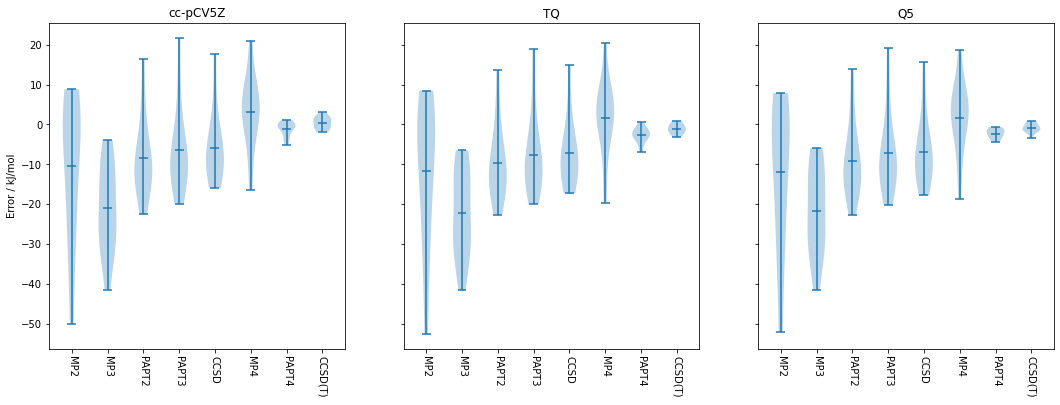

In [18]:
methods_pruned = methods[1:]
bases_pruned = ['cc-pCV5Z','TQ','Q5']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18,6))

for pane in range(len(bases_pruned)):
    data=[]
    for method in methods_pruned:
        data.append(list(error_with_respect_to_experimental_enthalpy[bases_pruned[pane]][method].values()))
    panes[pane].violinplot(data,showmeans=True,showextrema=True,vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1,len(methods_pruned)+1),labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name+".violin.pdf")

### Mean error

In [19]:
def error(method, basis, name):
    return Molpro_enthalpy[method][basis][name]-Exp_enthalpy[name]

lit_exp_molpro_error={}
for name in reactions:
    lit_exp_molpro_error[name]={}
    for method in methods:
        lit_exp_molpro_error[name][method]={}
        for basis in bases:
            lit_exp_molpro_error[name][method][basis]={}
            test_enthalpy = Molpro_enthalpy[method][basis][name]
            comparison_enthalpy = Exp_enthalpy[name]
            error = test_enthalpy - comparison_enthalpy
            lit_exp_molpro_error[name][method][basis] =+ error

lit_exp_molpro_meanerror={}
for method in methods:
    lit_exp_molpro_meanerror[method]={}
    for basis in bases:
        lit_exp_molpro_meanerror[method][basis]={}
        error_sum = 0
        for name in reactions:
            error_sum += lit_exp_molpro_error[name][method][basis]
        mean_error = error_sum / len(reactions)
        lit_exp_molpro_meanerror[method][basis] =+ mean_error

In [20]:
df_exp_reaction_meanerror=pd.DataFrame(data=lit_exp_molpro_meanerror)

In [21]:
df_exp_reaction_meanerror

,HF,MP2,MP3,PAPT2,PAPT3,CCSD,MP4,PAPT4,CCSD(T)
cc-pCVDZ,14.95,22.20,8.58,22.26,22.85,25.40,35.42,32.63,33.39
cc-pCVTZ,13.32,0.33,-11.89,1.37,3.03,4.47,14.12,9.73,11.31
cc-pCVQZ,10.73,-7.64,-18.94,-6.04,-4.22,-3.32,5.86,1.46,3.02
cc-pCV5Z,9.25,-10.49,-21.00,-8.27,-6.37,-5.78,3.06,-1.12,0.39
DT,13.32,-8.20,-19.82,-6.73,-4.63,-3.65,5.84,0.78,2.70
TQ,10.73,-11.56,-22.19,-9.55,-7.61,-7.11,1.72,-2.69,-1.13
Q5,9.25,-11.94,-21.61,-9.05,-7.09,-6.81,1.68,-2.28,-0.83


### Mean absolute error

In [22]:
lit_exp_molpro_abserror={}
for name in reactions:
    lit_exp_molpro_abserror[name]={}
    for method in methods:
        lit_exp_molpro_abserror[name][method]={}
        for basis in bases:
            lit_exp_molpro_abserror[name][method][basis]={}
            test_enthalpy = Molpro_enthalpy[method][basis][name]
            comparison_enthalpy = Exp_enthalpy[name]
            error = abs(test_enthalpy - comparison_enthalpy)
            lit_exp_molpro_abserror[name][method][basis] =+ error


lit_exp_molpro_meanabserror={}
for method in methods:
    lit_exp_molpro_meanabserror[method]={}
    for basis in bases:
        lit_exp_molpro_meanabserror[method][basis]={}
        error_sum = 0
        for name in reactions:
            error_sum += lit_exp_molpro_abserror[name][method][basis]
        mean_error = error_sum / len(reactions)
        lit_exp_molpro_meanabserror[method][basis] =+ mean_error

In [23]:
df_exp_reaction_meanabserror=pd.DataFrame(data=lit_exp_molpro_meanabserror)

In [24]:
df_exp_reaction_meanabserror

,HF,MP2,MP3,PAPT2,PAPT3,CCSD,MP4,PAPT4,CCSD(T)
cc-pCVDZ,29.77,30.99,17.23,29.13,29.67,30.85,38.42,36.65,36.73
cc-pCVTZ,28.67,13.74,12.20,8.12,8.76,7.86,16.36,11.24,12.05
cc-pCVQZ,29.14,13.49,18.94,9.84,9.37,7.36,9.36,3.15,3.70
cc-pCV5Z,29.06,14.46,21.00,11.51,10.92,9.37,7.31,1.38,1.30
DT,28.67,12.39,19.82,10.43,9.91,7.62,10.28,4.11,4.37
TQ,29.14,14.76,22.19,12.00,11.39,9.94,6.93,2.78,1.33
Q5,29.06,15.42,21.61,11.71,11.10,9.93,7.03,2.28,1.19


### Maximum error

In [25]:
lit_exp_molpro_maxerror={}
for method in methods:
    lit_exp_molpro_maxerror[method]={}
    for basis in bases:
        lit_exp_molpro_maxerror[method][basis]={}
        max_error = 0
        for name in reactions:
            if abs(lit_exp_molpro_error[name][method][basis]) > abs(max_error):
                max_error = lit_exp_molpro_error[name][method][basis]
        lit_exp_molpro_maxerror[method][basis] =+ max_error

In [26]:
df_exp_reaction_maxerror=pd.DataFrame(data=lit_exp_molpro_maxerror)

In [27]:
df_exp_reaction_maxerror

,HF,MP2,MP3,PAPT2,PAPT3,CCSD,MP4,PAPT4,CCSD(T)
cc-pCVDZ,115.10,76.54,-34.35,48.95,48.41,51.60,85.94,64.50,65.92
cc-pCVTZ,112.33,-44.43,-26.22,24.64,29.20,24.35,41.33,19.45,21.33
cc-pCVQZ,113.18,-48.75,-37.37,18.58,23.54,19.28,26.73,-5.96,6.97
cc-pCV5Z,113.66,-50.01,-41.36,-22.48,21.64,17.72,20.77,-5.07,3.00
DT,112.33,-49.48,-41.35,-21.81,24.22,19.85,24.17,11.96,10.79
TQ,113.18,-52.53,-41.50,-22.64,-19.89,-17.21,20.39,-6.89,-3.15
Q5,113.66,-51.83,-41.44,-22.76,-20.04,-17.75,-18.71,-4.34,-3.49


### Standard deviation

In [28]:
lit_exp_molpro_std={}
for method in methods:
    lit_exp_molpro_std[method]={}
    for basis in bases:
        lit_exp_molpro_std[method][basis]={}
        sum_squared_errors = 0
        for name in reactions:
            squared_error = (lit_exp_molpro_error[name][method][basis] - lit_exp_molpro_meanerror[method][basis]) ** 2
            sum_squared_errors += squared_error
        SD_squared = sum_squared_errors / (len(reactions)-1)
        SD = np.sqrt(SD_squared)
        lit_exp_molpro_std[method][basis] = SD

In [29]:
df_exp_reaction_std=pd.DataFrame(data=lit_exp_molpro_std)

In [30]:
df_exp_reaction_std

,HF,MP2,MP3,PAPT2,PAPT3,CCSD,MP4,PAPT4,CCSD(T)
cc-pCVDZ,39.46,31.15,18.68,23.01,23.16,22.61,30.93,26.50,25.92
cc-pCVTZ,39.03,19.53,9.12,10.52,11.23,9.03,14.50,8.46,8.07
cc-pCVQZ,40.60,18.27,10.14,9.84,10.62,8.65,10.44,3.30,2.88
cc-pCV5Z,41.24,18.17,11.05,10.11,10.88,9.20,9.15,1.83,1.51
DT,39.03,16.85,12.31,11.31,11.89,9.31,10.62,5.93,4.83
TQ,40.60,18.42,10.97,9.62,10.36,8.75,9.59,1.93,1.23
Q5,41.24,18.70,10.99,9.60,10.37,9.04,9.14,1.25,1.22


In [31]:
with open(project_name+'.tex','w') as tf:
    tf.write('\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}')
    tf.write(df_exp_reaction_meanerror.style.to_latex())
    tf.write(df_exp_reaction_std.style.to_latex())
    tf.write(df_exp_reaction_meanabserror.style.to_latex())
    tf.write(df_exp_reaction_maxerror.style.to_latex())